## Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [1]:
# To get rid of those blocks of red warnings
import warnings
warnings.filterwarnings("ignore")

# Standard Imports
import numpy as np
from scipy import stats
import pandas as pd
from math import sqrt
import os
from scipy.stats import spearmanr
from sklearn import metrics

# Vis Imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas.plotting import register_matplotlib_converters


# Modeling Imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import sklearn.preprocessing
import statsmodels.api as sm

# Custom Module Imports
import env

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

In [4]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

### Detecting Anomalies in Discrete Variables


In [5]:
df.ip.value_counts().head()


97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
Name: ip, dtype: int64

In [6]:
df.ip.value_counts(normalize=True).head()


97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
Name: ip, dtype: float64

In [7]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [8]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


<AxesSubplot:>

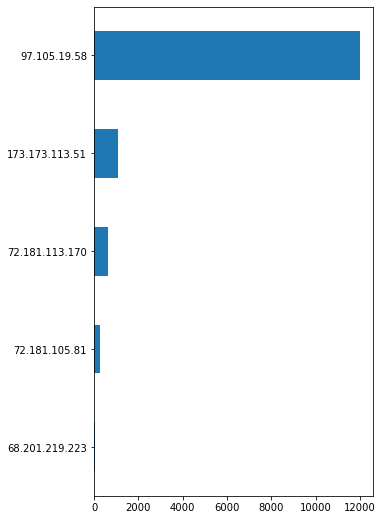

In [9]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))


### Conditional Probabilities: Probabilities using 2 discrete variables


In [10]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


#### If the probability of a status given the ip address is 100%, we know that that was the only status code seen by that ip address. To detect anomalies here we could look for two things:

- Cases where the probability is < 100% -- this means that multiple different status codes were encountered from the given ip address
- Status codes other than 200. 200 is the most common response code in our dataset by far.

In [11]:
status_given_ip[status_given_ip.status_code != '200']


,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


In [12]:
df[df.ip == '97.105.15.120']


,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441


In [13]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]


,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


## ## Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [15]:
df.head(1)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753


In [14]:
df.request_method.value_counts().head()


GET    13978
Name: request_method, dtype: int64

In [17]:
for col in df:
    print(df[col].value_counts().head())


97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
Name: ip, dtype: int64
GET    13978
Name: request_method, dtype: int64
/api/v1/sales?page=2    709
/api/v1/items           464
/api/v1/items?page=2    291
/api/v1/items?page=3    219
/api/v1/stores          162
Name: request_path, dtype: int64
HTTP/1.1    13978
Name: http_version, dtype: int64
200    13960
499       16
301        2
Name: status_code, dtype: int64
494819    705
3561      548
3659      291
1328      229
1787      219
Name: size, dtype: int64
python-requests/2.21.0                                                                                                       12005
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; In

In [18]:
for col in df:
    print(df[col].value_counts(normalize=True).head())

97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
Name: ip, dtype: float64
GET    1.0
Name: request_method, dtype: float64
/api/v1/sales?page=2    0.050723
/api/v1/items           0.033195
/api/v1/items?page=2    0.020818
/api/v1/items?page=3    0.015667
/api/v1/stores          0.011590
Name: request_path, dtype: float64
HTTP/1.1    1.0
Name: http_version, dtype: float64
200    0.998712
499    0.001145
301    0.000143
Name: status_code, dtype: float64
494819    0.050436
3561      0.039204
3659      0.020818
1328      0.016383
1787      0.015667
Name: size, dtype: float64
python-requests/2.21.0                                                                                                       0.858850
python-requests/2.20.1                                                                                                       0.136715
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (K

In [20]:
for col in df:
    print(value_counts_and_frequencies(df[col]))


                count     proba
97.105.19.58    11999  0.858420
173.173.113.51   1059  0.075762
72.181.113.170    613  0.043855
72.181.105.81     246  0.017599
68.201.219.223     21  0.001502
24.26.242.9        21  0.001502
35.175.171.137      2  0.000143
52.87.230.102       2  0.000143
70.121.214.34       2  0.000143
52.90.165.200       1  0.000072
95.31.16.121        1  0.000072
95.31.18.119        1  0.000072
45.23.250.16        1  0.000072
52.91.30.150        1  0.000072
34.207.64.242       1  0.000072
3.88.129.158        1  0.000072
54.172.14.223       1  0.000072
3.92.201.136        1  0.000072
35.174.209.2        1  0.000072
54.145.52.184       1  0.000072
34.229.70.250       1  0.000072
97.105.15.120       1  0.000072
     count  proba
GET  13978    1.0
                                 count     proba
/api/v1/sales?page=2               709  0.050723
/api/v1/items                      464  0.033195
/api/v1/items?page=2               291  0.020818
/api/v1/items?page=3            

In [21]:
request_path_df = value_counts_and_frequencies(df.request_path)
request_path_df.head()

,count,proba
/api/v1/sales?page=2,709,0.050723
/api/v1/items,464,0.033195
/api/v1/items?page=2,291,0.020818
/api/v1/items?page=3,219,0.015667
/api/v1/stores,162,0.011590


<AxesSubplot:>

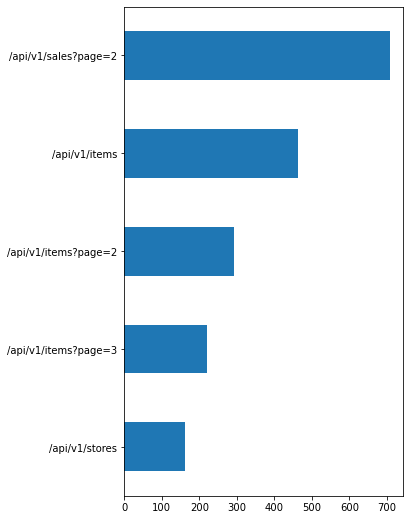

In [24]:
request_path_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))


<AxesSubplot:>

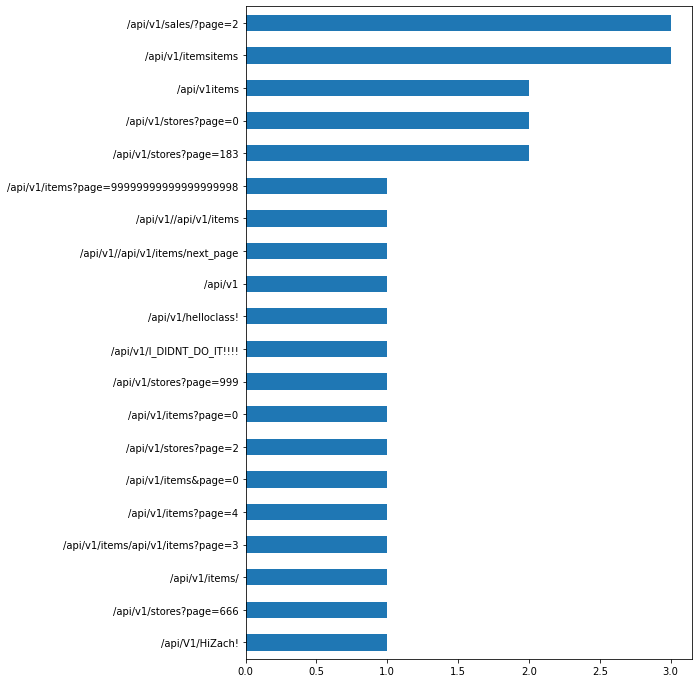

In [29]:
request_path_df['count'].sort_values().head(20).plot.barh(figsize=(8, 12))


In [30]:
status_code_df = value_counts_and_frequencies(df.status_code)
status_code_df.head()

,count,proba
200,13960,0.998712
499,16,0.001145
301,2,0.000143


<AxesSubplot:>

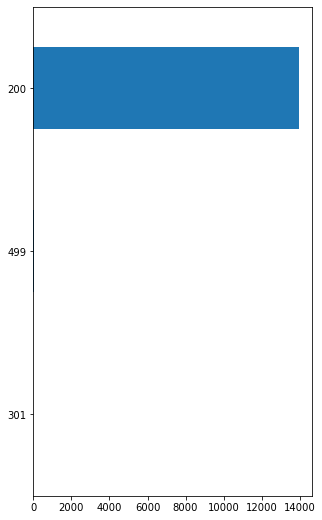

In [31]:
status_code_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))


In [33]:
user_agent_df = value_counts_and_frequencies(df.user_agent)
user_agent_df.head()

,count,proba
python-requests/2.21.0,12005,0.858850
python-requests/2.20.1,1911,0.136715
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,0.002432
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,0.000501


<AxesSubplot:>

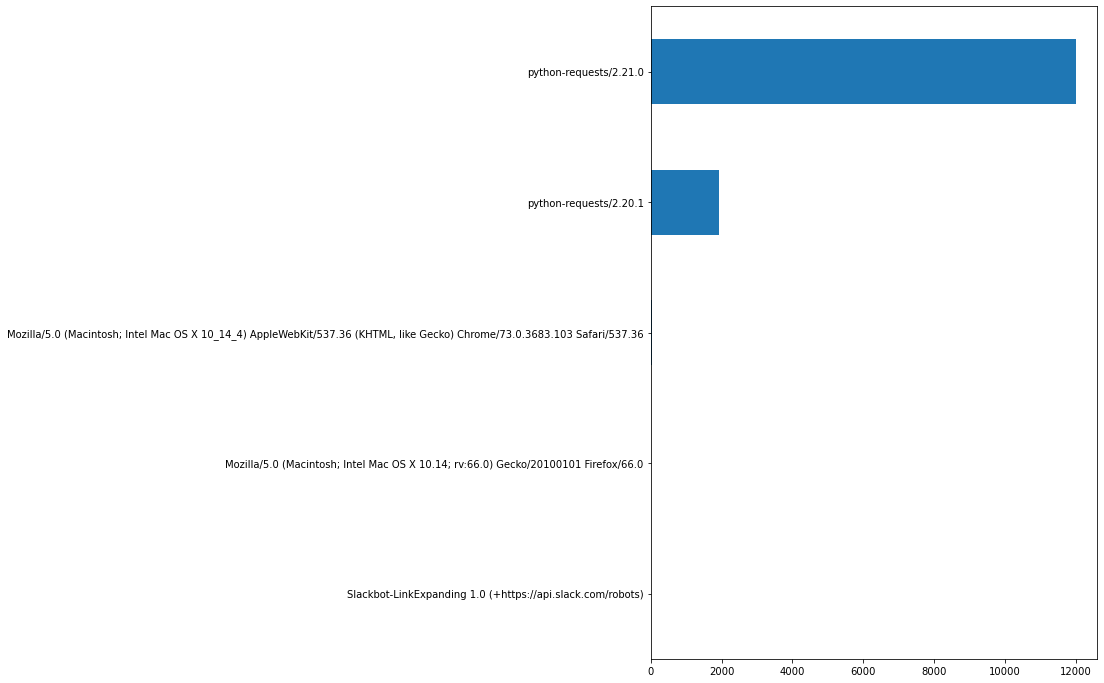

In [35]:
user_agent_df['count'].sort_values().tail(5).plot.barh(figsize=(8, 12))


In [36]:
size_mb = value_counts_and_frequencies(df.size_mb)
size_mb.head()

,count,proba
0.471896,705,0.050436
0.003396,548,0.039204
0.003489,291,0.020818
0.001266,229,0.016383
0.001704,219,0.015667


<AxesSubplot:>

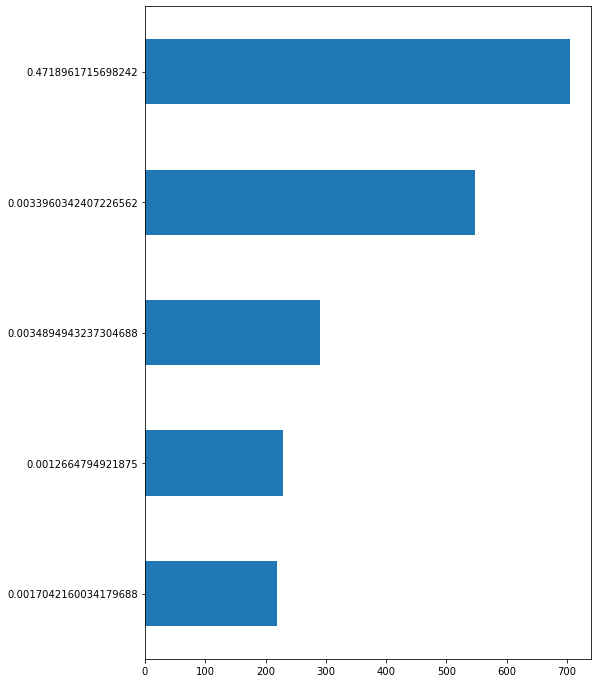

In [37]:
size_mb['count'].sort_values().tail(5).plot.barh(figsize=(8, 12))


In [38]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [39]:
user_agent_ip = (
    df.groupby('ip')
    .user_agent.value_counts(normalize=True)
    .rename('proba_status_user_agent')
    .reset_index()
)
user_agent_ip.head()

,ip,user_agent,proba_status_user_agent
0,173.173.113.51,python-requests/2.21.0,1.0
1,24.26.242.9,python-requests/2.21.0,1.0
2,3.88.129.158,Slackbot-LinkExpanding 1.0 (+https://api.slack...,1.0
3,3.92.201.136,Slackbot-LinkExpanding 1.0 (+https://api.slack...,1.0
4,34.207.64.242,Slackbot 1.0 (+https://api.slack.com/robots),1.0


In [40]:
user_agent_ip[user_agent_ip.proba_status_user_agent < 1]


,ip,user_agent,proba_status_user_agent
9,52.87.230.102,Slackbot 1.0 (+https://api.slack.com/robots),0.500000
10,52.87.230.102,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.500000
17,72.181.105.81,python-requests/2.21.0,0.934959
18,72.181.105.81,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.032520
19,72.181.105.81,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.032520
20,72.181.113.170,python-requests/2.21.0,0.996737
21,72.181.113.170,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.003263
25,97.105.19.58,python-requests/2.21.0,0.838320
26,97.105.19.58,python-requests/2.20.1,0.159263
27,97.105.19.58,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002167
